# Setup the data in the proper format
### (should take a couple minutes to run these first few cells)

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

from classes import dataType
from functions import cross_val, fit_clf, create_roc, find_acc_eta, find_acc_phi, find_acc_pt
from functions import get_score_err, split_50, acc_thresh_plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import resample, shuffle
from sklearn.utils.random import sample_without_replacement
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
pt_cutl = 20
pt_cuth = 100

In [3]:
# take in .root into arrays
arrays_qcd = (uproot.open("data/qcdflat_pu200_allevt_loose_and_cuts.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

# create data in proper format
data_qcd = dataType(arrays_qcd)

In [4]:
# take in .root into arrays
arrays_mu = (uproot.open("data/ZMM_pu200_loose_and_cuts.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

# create data in proper format
data_mu = dataType(arrays_mu)

In [5]:
# take in .root into arrays
arrays_elec = (uproot.open("data/ZEE_pu200_loose_and_cuts.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

# create data in proper format
data_elec = dataType(arrays_elec)

In [6]:
#collect all muons, electrons, hadrons and fakes from the samples
X_mu = np.concatenate((data_mu.trks.X[abs(data_mu.trks.pdgid)==13],data_elec.trks.X[abs(data_elec.trks.pdgid)==13],data_qcd.trks.X[abs(data_qcd.trks.pdgid)==13]))
y_mu = np.concatenate((data_mu.trks.y[abs(data_mu.trks.pdgid)==13],data_elec.trks.y[abs(data_elec.trks.pdgid)==13],data_qcd.trks.y[abs(data_qcd.trks.pdgid)==13]))
pdgid_mu = np.concatenate((data_mu.trks.pdgid[abs(data_mu.trks.pdgid)==13],data_elec.trks.pdgid[abs(data_elec.trks.pdgid)==13],data_qcd.trks.pdgid[abs(data_qcd.trks.pdgid)==13]))
X_mu,y_mu,pdgid_mu = shuffle(X_mu,y_mu,pdgid_mu)

X_elec = np.concatenate((data_mu.trks.X[abs(data_mu.trks.pdgid)==11],data_elec.trks.X[abs(data_elec.trks.pdgid)==11],data_qcd.trks.X[abs(data_qcd.trks.pdgid)==11]))
y_elec = np.concatenate((data_mu.trks.y[abs(data_mu.trks.pdgid)==11],data_elec.trks.y[abs(data_elec.trks.pdgid)==11],data_qcd.trks.y[abs(data_qcd.trks.pdgid)==11]))
pdgid_elec = np.concatenate((data_mu.trks.pdgid[abs(data_mu.trks.pdgid)==11],data_elec.trks.pdgid[abs(data_elec.trks.pdgid)==11],data_qcd.trks.pdgid[abs(data_qcd.trks.pdgid)==11]))
X_elec,y_elec,pdgid_elec = shuffle(X_elec,y_elec,pdgid_elec)

X_qcd = np.concatenate((data_mu.trks.X[np.logical_and(abs(data_mu.trks.pdgid)>37,abs(data_mu.trks.pdgid)!=999)],data_elec.trks.X[np.logical_and(abs(data_elec.trks.pdgid)>37,abs(data_elec.trks.pdgid)!=999)],data_qcd.trks.X[np.logical_and(abs(data_qcd.trks.pdgid)>37,abs(data_qcd.trks.pdgid)!=999)]))
y_qcd = np.concatenate((data_mu.trks.y[np.logical_and(abs(data_mu.trks.pdgid)>37,abs(data_mu.trks.pdgid)!=999)],data_elec.trks.y[np.logical_and(abs(data_elec.trks.pdgid)>37,abs(data_elec.trks.pdgid)!=999)],data_qcd.trks.y[np.logical_and(abs(data_qcd.trks.pdgid)>37,abs(data_qcd.trks.pdgid)!=999)]))
pdgid_qcd = np.concatenate((data_mu.trks.pdgid[np.logical_and(abs(data_mu.trks.pdgid)>37,abs(data_mu.trks.pdgid)!=999)],data_elec.trks.pdgid[np.logical_and(abs(data_elec.trks.pdgid)>37,abs(data_elec.trks.pdgid)!=999)],data_qcd.trks.pdgid[np.logical_and(abs(data_qcd.trks.pdgid)>37,abs(data_qcd.trks.pdgid)!=999)]))
X_qcd,y_qcd,pdgid_qcd = shuffle(X_qcd,y_qcd,pdgid_qcd)

X_fake = np.concatenate((data_mu.trks.X[abs(data_mu.trks.pdgid)==999],data_elec.trks.X[abs(data_elec.trks.pdgid)==999],data_qcd.trks.X[abs(data_qcd.trks.pdgid)==999]))
y_fake = np.concatenate((data_mu.trks.y[abs(data_mu.trks.pdgid)==999],data_elec.trks.y[abs(data_elec.trks.pdgid)==999],data_qcd.trks.y[abs(data_qcd.trks.pdgid)==999]))
pdgid_fake = np.concatenate((data_mu.trks.pdgid[abs(data_mu.trks.pdgid)==999],data_elec.trks.pdgid[abs(data_elec.trks.pdgid)==999],data_qcd.trks.pdgid[abs(data_qcd.trks.pdgid)==999]))
X_fake,y_fake,pdgid_fake = shuffle(X_fake,y_fake,pdgid_fake)

In [7]:
#create train and test sets with 2500 of each mu, elec, had, fake in train, rest in test
mu_cutidx = np.logical_and(X_mu[:,0]>pt_cutl,X_mu[:,0]<pt_cuth)
elec_cutidx = np.logical_and(X_elec[:,0]>pt_cutl,X_elec[:,0]<pt_cuth)
qcd_cutidx = np.logical_and(X_qcd[:,0]>pt_cutl,X_qcd[:,0]<pt_cuth)
fake_cutidx = np.logical_and(X_fake[:,0]>pt_cutl,X_fake[:,0]<pt_cuth)

mu_idx = sample_without_replacement(len(X_mu[mu_cutidx]),2500,random_state=23)
elec_idx = sample_without_replacement(len(X_elec[elec_cutidx]),2500,random_state=23)
qcd_idx = sample_without_replacement(len(X_qcd[qcd_cutidx]),2500,random_state=23)
fake_idx = sample_without_replacement(len(X_fake[fake_cutidx]),2500,random_state=23)

X_train = np.concatenate((X_mu[mu_cutidx][mu_idx],X_elec[elec_cutidx][elec_idx],X_qcd[qcd_cutidx][qcd_idx],X_fake[fake_cutidx][fake_idx]))
y_train = np.concatenate((y_mu[mu_cutidx][mu_idx],y_elec[elec_cutidx][elec_idx],y_qcd[qcd_cutidx][qcd_idx],y_fake[fake_cutidx][fake_idx]))
pdgid_train = np.concatenate((pdgid_mu[mu_cutidx][mu_idx],pdgid_elec[elec_cutidx][elec_idx],pdgid_qcd[qcd_cutidx][qcd_idx],pdgid_fake[fake_cutidx][fake_idx]))

X_test = np.concatenate((np.delete(X_mu[mu_cutidx],mu_idx,axis=0),np.delete(X_elec[elec_cutidx],elec_idx,axis=0),np.delete(X_qcd[qcd_cutidx],qcd_idx,axis=0),np.delete(X_fake[fake_cutidx],fake_idx,axis=0)))
y_test = np.concatenate((np.delete(y_mu[mu_cutidx],mu_idx,axis=0),np.delete(y_elec[elec_cutidx],elec_idx,axis=0),np.delete(y_qcd[qcd_cutidx],qcd_idx,axis=0),np.delete(y_fake[fake_cutidx],fake_idx,axis=0)))
pdgid_test = np.concatenate((np.delete(pdgid_mu[mu_cutidx],mu_idx,axis=0),np.delete(pdgid_elec[elec_cutidx],elec_idx,axis=0),np.delete(pdgid_qcd[qcd_cutidx],qcd_idx,axis=0),np.delete(pdgid_fake[fake_cutidx],fake_idx,axis=0)))

X_train,y_train,pdgid_train = shuffle(X_train,y_train,pdgid_train,random_state=23)
X_test,y_test,pdgid_test = shuffle(X_test,y_test,pdgid_test,random_state=23)

### A look at all of the track properties we have to work with

In [8]:
data_qcd.trks.X_feats

['trk_pt',
 'trk_phi',
 'trk_eta',
 'trk_z0',
 'trk_chi2pdof',
 'trk_bendchi2',
 'trk_nstub',
 'trk_stubs_layer1',
 'trk_stubs_layer2',
 'trk_stubs_layer3',
 'trk_stubs_layer4',
 'trk_stubs_layer5',
 'trk_stubs_layer6',
 'trk_nlayer_miss',
 'trk_stubs_ps']

# Create different classifiers and test them against each other

In [9]:
# need to clear full session if you make a change to a current existing NN
from keras import backend as K 
K.clear_session()

In [10]:
clf_NN = Sequential()
clf_NN.add(Dense(15, input_dim=14, activation='relu')) # each Dense layer is a fully-connected layer in the NN being added
clf_NN.add(Dense(8, activation='relu'))
clf_NN.add(Dense(1, activation='sigmoid'))
clf_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
clf_NN.fit(X_train[:,1:], y_train, epochs=80, batch_size=50, verbose=0) #verbose is supressing output

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
clf_GBDT = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=23)
clf_GBDT.fit(X_train[:,1:],y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=23, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [12]:
#create ROC curve with each classifier compared against each other and a set of cuts
def create_roc(X, y, fit_clfs, clf_labels):
    
    plt.figure(figsize=(6,6))
    
    # find tpr and fpr for 
    for ii in range(len(fit_clfs)):
        fit_clf = fit_clfs[ii]
        X_cols = list(range(1,15))
            
        if 'NN' in clf_labels[ii]:
            y_pred = fit_clf.predict(X[:,X_cols])[:,0]
        else:
            y_pred = np.sum(fit_clf.predict_proba(X[:,X_cols])[:,1:],axis=1)
        fpr, tpr, _ = roc_curve(y,y_pred)
        auc = roc_auc_score(y, y_pred)
        plt.plot(fpr, tpr, label=clf_labels[ii]+' ('+str(round(auc,3))+')', linewidth=2)

    #compare against your favorite set of cuts
    y_pred_base = np.zeros(len(y))
    for ii in range(len(y)):
        if X[ii,0]>2 and abs(X[ii,2])<2.4 and X[ii,6]>=4 and abs(X[ii,3])<15 and X[ii,4]<40 and X[ii,5]<2.4:
            y_pred[ii] = 1 
    fpr_base = np.count_nonzero(y_pred[y==0]==1)/np.count_nonzero(y==0)
    tpr_base = np.count_nonzero(y_pred[y==1]==1)/np.count_nonzero(y==1)
    plt.scatter(fpr_base, tpr_base, s=80,marker='*', label='trkMet cuts',color='red')

    plt.tick_params(labelsize=14)
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.xlim(0, .3)
    plt.ylim(.9, 1)
    plt.legend(loc='best',fontsize=14)
    plt.show()
    
    return

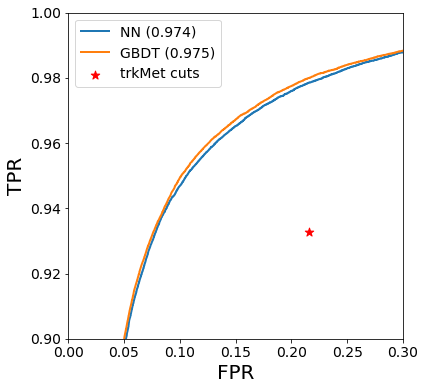

In [13]:
create_roc(X_test,y_test,[clf_NN,clf_GBDT],['NN','GBDT']) # can include more models to compare against

In [14]:
def get_base_eff_faker_err(X, y_true):

    y_pred = np.zeros(len(y_true))
    for ii in range(len(y_true)):
        if X[ii,0]>2 and abs(X[ii,2])<2.4 and X[ii,6]>=4 and abs(X[ii,3])<15 and X[ii,4]<40 and X[ii,5]<2.4:
            y_pred[ii] = 1
    
    return get_eff_faker_err(y_pred,y_true)

def get_eff_faker_err(y_pred, y_true):

    # efficiency = (# reals labeled real)/(# reals) <-this is really TPR
    TP = (y_pred[y_true==1]==1).sum()
    reals = len(y_true[y_true==1])
    eff = TP/reals
    err_eff = np.sqrt(TP*(reals-TP)/reals**3)

    if y_true.all()==1:
        return eff, 0, err_eff, 0
    
    # fake rate = (# fakes labeled real)/(#fakes) <-this is really FPR
    FP = (y_pred[y_true==0]==1).sum()
    fakes = len(y_true[y_true==0])
    faker = FP/fakes
    err_faker = np.sqrt(FP*(fakes-FP)/fakes**3)
    
    return eff, faker, err_eff, err_faker

#look at FPR and TPR vs. p_t
def find_eff_faker_pt(X_feats, X, y, fit_clf, clf_label, thresh=.5):
    
    pt_idx = X_feats.index('trk_pt')   
    bins = np.logspace(1.3,2,12) #20 to 100 GeV
       
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
    
    plt.figure(figsize=(6,6))
    
    for kk in range(len(clf_label)):
        eff = np.zeros(len(bins))
        faker = np.zeros(len(bins))
        err_eff = np.zeros(len(bins))
        err_faker = np.zeros(len(bins))
        
        X_cols = list(range(1,15))
            
        for ii in range(len(bins)):
            idx_temp = np.digitize(X[:,pt_idx],bins,right=True)==ii
            X_temp = X[idx_temp]
            y_temp = y[idx_temp]
            if len(X_temp)>0:
                if 'NN' in clf_label[kk]:
                    y_pred = fit_clf[kk].predict(X_temp[:,X_cols])[:,0]
                else:
                    y_pred = np.sum(fit_clf[kk].predict_proba(X_temp[:,X_cols])[:,1:],axis=1)
                y_pred[y_pred<thresh] = 0
                y_pred[y_pred>=thresh] = 1
                eff[ii], faker[ii], err_eff[ii], err_faker[ii] = get_eff_faker_err(y_pred,y_temp)
        ax1.errorbar(bins[eff>0],eff[eff>0],yerr=err_eff[eff>0],linestyle='None',fmt='.',label=clf_label[kk],markersize=10,elinewidth=3)
        ax2.errorbar(bins[faker>0],faker[faker>0],yerr=err_faker[faker>0],linestyle='None',fmt='.',label=clf_label[kk],markersize=10,elinewidth=3)
    
    #test against your favorite set of cuts
    base_scores = np.zeros(len(bins))
    base_err = np.zeros(len(bins))
    for ii in range(len(bins)):
        idx_temp = np.digitize(X[:,pt_idx],bins,right=True)==ii
        X_temp = X[idx_temp]
        y_temp = y[idx_temp]
        if len(X_temp)>0:
            eff[ii], faker[ii], err_eff[ii], err_faker[ii] = get_base_eff_faker_err(X_temp,y_temp)
    ax1.errorbar(bins[eff>0],eff[eff>0],yerr=err_eff[eff>0],linestyle='None',fmt='.',label='trkMET cuts',markersize=10,elinewidth=3)
    ax2.errorbar(bins[faker>0],faker[faker>0],yerr=err_faker[faker>0],linestyle='None',fmt='.',label='trkMET cuts',markersize=10,elinewidth=3)
    
    ax1.set_xlabel('p$_{T}$ (GeV/c)',fontsize=20)
    ax1.set_ylabel('TPR',fontsize=20)
    ax1.legend(loc='best',fontsize=14)
    ax1.set_ylim(.9,1.03)
    
    ax2.set_xlabel('p$_{T}$ (GeV/c)',fontsize=20)
    ax2.set_ylabel('FPR',fontsize=20)
    ax2.legend(loc='lower right',fontsize=14) 
    ax2.set_ylim(0.05,.3)
    ax2.legend(loc='lower right',fontsize=14) 

    return

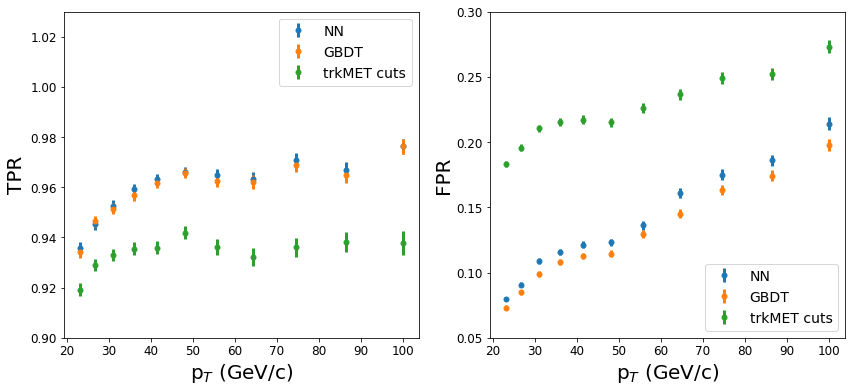

<Figure size 432x432 with 0 Axes>

In [15]:
find_eff_faker_pt(data_mu.trks.X_feats,X_test,y_test,[clf_NN,clf_GBDT],['NN','GBDT'],.6) # can include more models to compare against

In [20]:
def get_base_eff_faker_err(X, y_true):

    y_pred = np.zeros(len(y_true))
    for ii in range(len(y_true)):
        if X[ii,0]>2 and abs(X[ii,2])<2.4 and X[ii,6]>=4 and abs(X[ii,3])<15 and X[ii,4]<50 and X[ii,5]<1.75:
            y_pred[ii] = 1
    
    return get_eff_faker_err(y_pred,y_true)

def get_eff_faker_err(y_pred, y_true):

    TP = (y_pred[y_true==1]==1).sum()
    reals = len(y_true[y_true==1])
    eff = TP/reals
    err_eff = np.sqrt(TP*(reals-TP)/reals**3)

    if y_true.all()==1:
        return eff, 0, err_eff, 0
    
    FP = (y_pred[y_true==0]==1).sum()
    fakes = len(y_true[y_true==0])
    faker = FP/fakes
    err_faker = np.sqrt(FP*(fakes-FP)/fakes**3)
    
    return eff, faker, err_eff, err_faker

#look at TPR vs p_t for each particle group
def find_eff_faker_pt_comp(X_feats, X, y, fit_clf, clf_label, X_label, thresh):
    
    pt_idx = X_feats.index('trk_pt')   
    bins = np.logspace(1.3,2,12) #20 to 100 GeV
       
    plt.figure(figsize=(6,6))
    
    for kk in range(len(X)):
        eff = np.zeros(len(bins))
        faker = np.zeros(len(bins))
        err_eff = np.zeros(len(bins))
        err_faker = np.zeros(len(bins))
        for ii in range(len(bins)):
            idx_temp = np.digitize(X[kk][:,pt_idx],bins,right=True)==ii
            X_temp = X[kk][idx_temp]
            y_temp = y[kk][idx_temp]
            if len(X_temp)>0:
                if clf_label=='NN':
                    y_pred = fit_clf.predict(X_temp[:,1:])[:,0] 
                else:
                    y_pred = np.sum(fit_clf.predict_proba(X_temp[:,1:])[:,1:],axis=1)
                y_pred[y_pred<thresh] = 0
                y_pred[y_pred>=thresh] = 1
                eff[ii], faker[ii], err_eff[ii], err_faker[ii] = get_eff_faker_err(y_pred,y_temp)
        plt.errorbar(bins[eff>0],eff[eff>0],yerr=err_eff[eff>0],linestyle='None',fmt='.',label=X_label[kk],markersize=10,elinewidth=3)

    plt.title(clf_label,fontsize=18)
    plt.tick_params(labelsize=12)
    plt.xlabel('$p_{T}$ (GeV/c)',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    plt.legend(loc='center right',fontsize=12)

    return

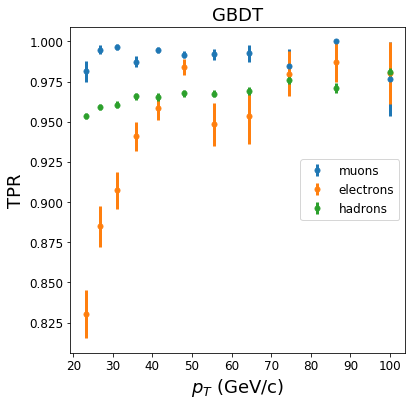

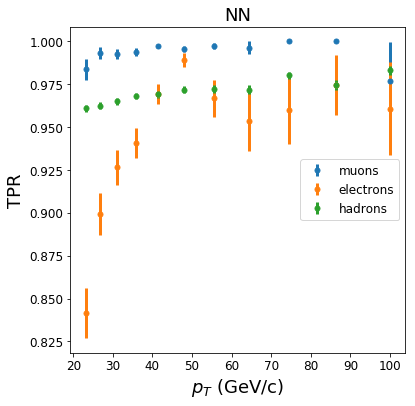

In [22]:
X_mu = X_test[abs(pdgid_test)==13]
X_elec = X_test[abs(pdgid_test)==11]
X_had = X_test[np.logical_and(abs(pdgid_test)>37,abs(pdgid_test)!=999)]
y_mu = y_test[abs(pdgid_test)==13]
y_elec = y_test[abs(pdgid_test)==11]
y_had = y_test[np.logical_and(abs(pdgid_test)>37,abs(pdgid_test)!=999)]
find_eff_faker_pt_comp(data_mu.trks.X_feats, [X_mu,X_elec,X_had], [y_mu,y_elec,y_had], 
                       clf_GBDT, 'GBDT',['muons','electrons','hadrons'],.5)
find_eff_faker_pt_comp(data_mu.trks.X_feats, [X_mu,X_elec,X_had], [y_mu,y_elec,y_had], 
                       clf_NN, 'NN',['muons','electrons','hadrons'],.5)

In [27]:
#look at TPR vs. decision threshold for the different particles
def find_eff_part_thresh_comp(X, y, fit_clf, clf_label, X_label):

    plt.figure(figsize=(6,6))
    
    bins = np.linspace(0,1,50)
    
    for kk in range(len(X)):
        eff = np.zeros(len(bins))
        err_eff = np.zeros(len(bins))
        for ii in range(len(bins)):
            if 'NN' in clf_label:
                y_pred = fit_clf.predict(X[kk][:,1:])[:,0]
            else:
                y_pred = np.sum(fit_clf.predict_proba(X[kk][:,1:])[:,1:],axis=1)
            y_pred[y_pred<bins[ii]] = 0
            y_pred[y_pred>=bins[ii]] = 1
            eff[ii], faker, err_eff[ii], err_faker = get_eff_faker_err(y_pred,y[kk])
        plt.errorbar(bins,eff,err_eff,linestyle='None',marker='.',label=X_label[kk],markersize=10,elinewidth=3)

    plt.title(clf_label,fontsize=20)
    plt.tick_params(labelsize=12)
    plt.xlabel('Decision Thresh.',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    plt.ylim(.6,1)
    plt.legend(loc='center left',fontsize=12)
    
    return

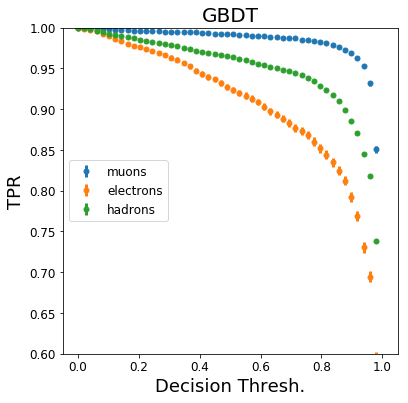

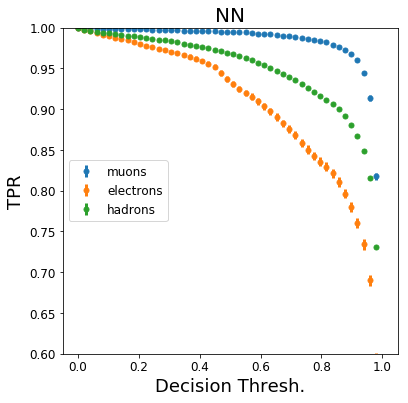

In [28]:
find_eff_part_thresh_comp([X_mu,X_elec,X_had], [y_mu,y_elec,y_had], clf_GBDT, 
                          'GBDT',['muons','electrons','hadrons'])
find_eff_part_thresh_comp([X_mu,X_elec,X_had], [y_mu,y_elec,y_had], clf_NN, 
                          'NN',['muons','electrons','hadrons'])